In [2]:
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [3]:
data = join('datasets', 'gdp_loans_monthly.csv')

df = pd.read_csv(data, parse_dates=[0], index_col=0, squeeze=True)

df.head(10)

,real_gdp,nom_gdp,loans,deposits,ipi_vol,ipi_val,pmi,gdp_yy,loans_yy,rr_rate,olfacility
date,,,,,,,,,,,
1997-01-01,NaN,NaN,1237287.0,1294703.5,NaN,NaN,NaN,NaN,NaN,10.50,NaN
1997-02-01,NaN,NaN,1264241.0,1315544.3,NaN,NaN,NaN,NaN,NaN,10.50,NaN
1997-03-01,1539321.159,636624.9867,1284591.0,1341784.8,NaN,NaN,NaN,NaN,NaN,9.90,NaN
1997-04-01,NaN,NaN,1326161.0,1341050.1,NaN,NaN,NaN,NaN,NaN,10.25,NaN
1997-05-01,NaN,NaN,1361678.0,1364119.7,NaN,NaN,NaN,NaN,NaN,16.00,NaN
1997-06-01,1593749.807,665181.7604,1418953.0,1411018.0,NaN,NaN,NaN,NaN,NaN,15.00,NaN
1997-07-01,NaN,NaN,1437033.0,1478025.6,NaN,NaN,NaN,NaN,NaN,20.00,NaN
1997-08-01,NaN,NaN,1405373.0,1490426.7,NaN,NaN,NaN,NaN,NaN,12.00,NaN
1997-09-01,1573879.492,678133.4885,1499248.0,1546017.7,NaN,NaN,NaN,NaN,NaN,12.00,NaN


C:\Users\Derrick\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


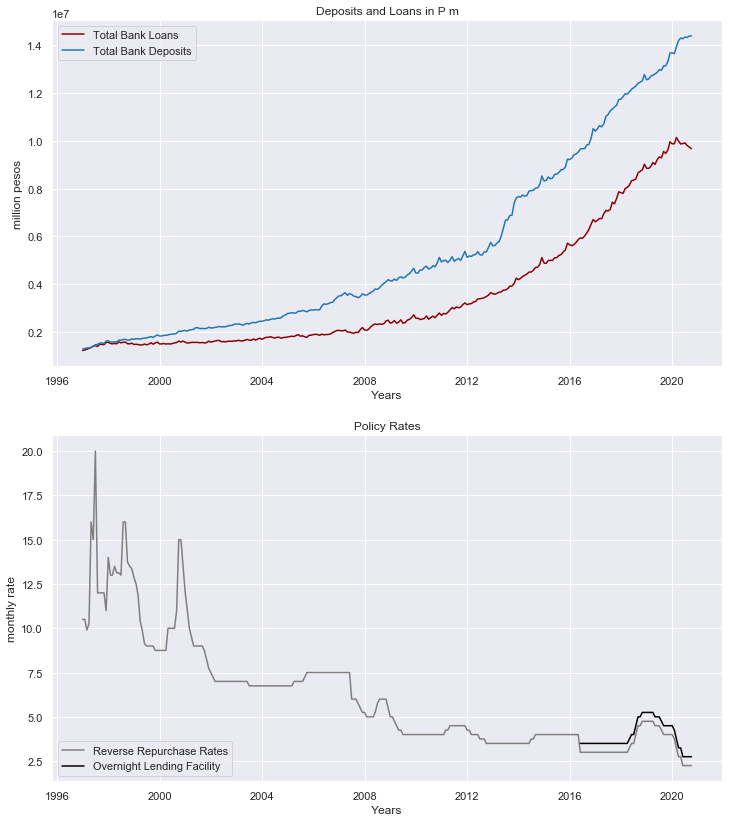

In [4]:
# plotting
sns.set(style="darkgrid")

fig = plt.figure(figsize=(12,14))

plt.subplot(2, 1, 1)
plt.plot(df.loans, color='darkred', label='Total Bank Loans')
plt.plot(df.deposits, color='tab:blue', label='Total Bank Deposits')
plt.title('Deposits and Loans in P m')
plt.legend()
plt.xlabel('Years')
plt.ylabel('million pesos')

plt.subplot(2, 1, 2)
plt.plot(df.rr_rate, color='tab:gray', label='Reverse Repurchase Rates')
plt.plot(df.olfacility, color='black', label='Overnight Lending Facility')
plt.title('Policy Rates')
plt.legend(loc=3)
plt.xlabel('Years')
plt.ylabel('monthly rate')

plt.show()


C:\Users\Derrick\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Derrick\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


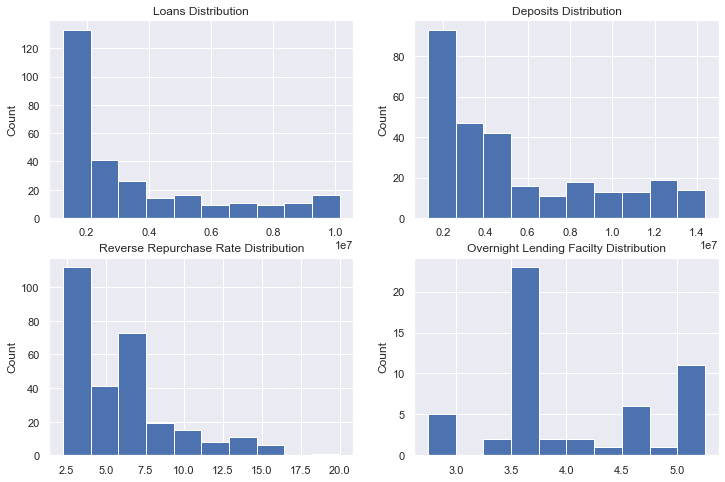

In [5]:
def all_dist():
    fig = plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    plt.hist(df.loans)
    plt.title('Loans Distribution')
    plt.ylabel('Count')

    plt.subplot(2,2,2)
    plt.hist(df.deposits)
    plt.title('Deposits Distribution')
    plt.ylabel('Count')

    plt.subplot(2, 2, 3)
    plt.hist(df.rr_rate)
    plt.title('Reverse Repurchase Rate Distribution')
    plt.ylabel('Count')

    plt.subplot(2, 2, 4)
    plt.hist(df.olfacility)
    plt.title('Overnight Lending Facilty Distribution')
    plt.ylabel('Count')
    
all_dist()

In [6]:
#testing for stationarity
def adf_test(series, name=None, num=None):
    result = adfuller(series)
    if name == None:
        name = str(series.name)
    if num != None:
        name = 'Series %s' % str(num)
    print('\n%s:' %name)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

    
loans = df.loans
deposits = df.deposits
policy = df.rr_rate

adf_test(loans)
print('Sample size: %s' %len(loans))
adf_test(deposits)
print('Sample size: %s' %len(deposits))
adf_test(policy)
print('Sample size: %s' %len(policy))


loans:
ADF Statistic: -1.662579
p-value: 0.450489
Sample size: 286

deposits:
ADF Statistic: 2.723327
p-value: 0.999088
Sample size: 286

rr_rate:
ADF Statistic: -2.531716
p-value: 0.107947
Sample size: 286


### Making Stationary

In [7]:
# The following code consolidates transofrmation steps into one (and backtracks transformations)
def normalize(series):
    ave, stdev = series.mean(), series.std()
    series = (series-ave)/stdev
    return series

def annual_vol(series):
    stdevs = series.groupby(series.index.year).std()
    return series.index.map(lambda d: stdevs.loc[d.year])

def variance_correct(series):
    return series/annual_vol(series)

def qtr_mean(series):
    means = series.groupby(series.index.month).mean()
    return series.index.map(lambda d: means.loc[d.month])

def seasonality_correct(series):
    return series - qtr_mean(series)

def make_stationary(*data, plot=False, headers=True):
    stdata = []
    for d in data:
        if headers == True:
            header = d.name
        d = normalize(d)
        d = d.diff().dropna()
        d = variance_correct(d)
        d = seasonality_correct(d).dropna()
        d.name = header
        stdata.append(d)
        
    if len(stdata) == 1:
        return stdata[0]
    else:
        return stdata



loans:
ADF Statistic: -7.122089
p-value: 0.000000
Sample size: 285

deposits:
ADF Statistic: -7.871357
p-value: 0.000000
Sample size: 285

rr_rate:
ADF Statistic: -5.384631
p-value: 0.000004
Sample size: 213


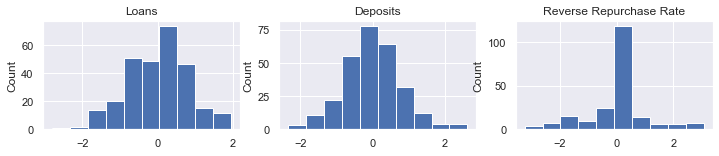

In [10]:
st_series = make_stationary(loans, deposits, policy)

for s in st_series:
    adf_test(s)
    s = s.fillna(method="bfill")
    print('Sample size: %s' %len(s))

fig = plt.figure(figsize=(12,2))

plt.subplot(1,3,1)
plt.hist(st_series[0])
plt.title('Loans')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(st_series[1])
plt.title('Deposits')
plt.ylabel('Count')

plt.subplot(1,3,3)
plt.hist(st_series[2])
plt.title('Reverse Repurchase Rate')
plt.ylabel('Count')

plt.show()

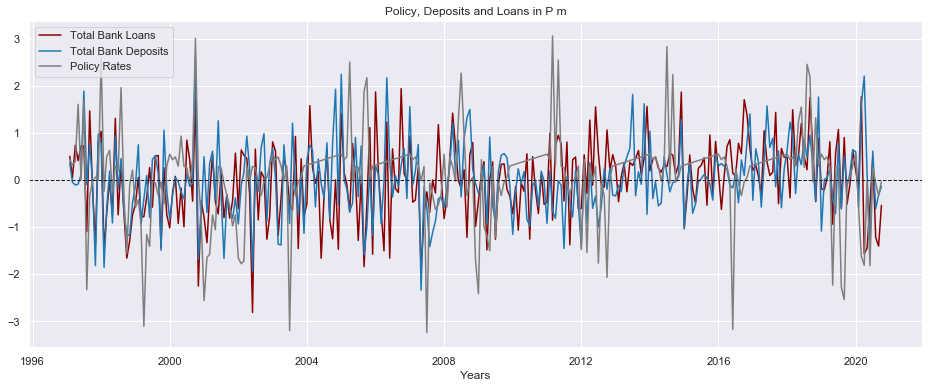

In [11]:
# plotting

loans = st_series[0]
deposits = st_series[1]
policy = st_series[2]

fig = plt.figure(figsize=(16,6))

plt.plot(loans, color='darkred', label='Total Bank Loans')
plt.plot(deposits, color='tab:blue', label='Total Bank Deposits')
plt.plot(policy, color='tab:gray', label='Policy Rates')
plt.title('Policy, Deposits and Loans in P m')
plt.legend()
plt.xlabel('Years')
#plt.ylabel('million pesos')
plt.axhline(linewidth=1, linestyle='dashed', color='k')

plt.show()


### Finding Granger Causality

In [12]:
def granger(s1, s2, lag=4):
    granger_df = pd.concat([s1, s2], axis=1).dropna()
    grangercausalitytests(granger_df, lag)

print('Testing causality\n')
granger(loans, policy)
print('\n-----------------------------------------------\n')
granger(deposits, policy)

Testing causality


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1654  , p=0.2816  , df_denom=209, df_num=1
ssr based chi2 test:   chi2=1.1822  , p=0.2769  , df=1
likelihood ratio test: chi2=1.1789  , p=0.2776  , df=1
parameter F test:         F=1.1654  , p=0.2816  , df_denom=209, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4917  , p=0.6123  , df_denom=206, df_num=2
ssr based chi2 test:   chi2=1.0074  , p=0.6043  , df=2
likelihood ratio test: chi2=1.0050  , p=0.6050  , df=2
parameter F test:         F=0.4917  , p=0.6123  , df_denom=206, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3966  , p=0.7556  , df_denom=203, df_num=3
ssr based chi2 test:   chi2=1.2307  , p=0.7456  , df=3
likelihood ratio test: chi2=1.2271  , p=0.7465  , df=3
parameter F test:         F=0.3966  , p=0.7556  , df_denom=203, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0

 ### Fitting VAR

In [13]:
### AUTOMATE MODEL SELECTION
def fit_tsmodel(data, model='VAR', lags=4):
    models = ['VAR','SARIMAX']

    if model in models:
        if model == models[0]:
            model = VAR
        elif model == models[1]:
            model == SARIMAX
    else:
        print('Model not supported')
        return None
    
    fmodel = model(data)          
    res = fmodel.fit(maxlags=lags)
    return res

**note: cite BSP study **

In [14]:
def create_df(*series):
    df = pd.concat(series, axis=1).dropna()
    n = []
    for i in series:
        n.append(i.name)
    df.columns = n
    return df

sdf = pd.concat([loans, deposits, policy], axis=1).dropna()

res = fit_tsmodel(sdf,lags=4)
res.summary()

C:\Users\Derrick\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 08, Jan, 2021
Time:                     14:30:16
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                  -0.478865
Nobs:                     209.000    HQIC:                 -0.850393
Log likelihood:          -735.458    FPE:                   0.332182
AIC:                     -1.10255    Det(Omega_mle):        0.277176
--------------------------------------------------------------------
Results for equation loans
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              -0.037305         0.056238           -0.663           0.507
L1.loans            0.035883         0.087479            0.410           0.682
L1.deposits        -0.217221         0.088810           -2.446      